# Import necessary libraries and python files

Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
from torch.nn import Linear, Dropout, BatchNorm1d, LayerNorm, MultiheadAttention, TransformerEncoderLayer
from torch.optim.optimizer import Optimizer

In [4]:
import joblib

Ensure torch is connected to GPU

In [5]:
torch.__version__

'2.0.0+cu117'

In [6]:
torch.cuda.is_available()

True

In [7]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



Mount Drive and Load files/functions from other colab/jupyter notebooks

In [8]:
# Install the ipynb library
!pip install import-ipynb
import import_ipynb

Import Necessary Colab Notebooks

In [9]:
import dataset_prep
import Transformer_loss_activation_and_optimizer_functions
import Encoder_Transformer_Layers

importing Jupyter notebook from dataset_prep.ipynb
importing Jupyter notebook from Transformer_loss_activation_and_optimizer_functions.ipynb
importing Jupyter notebook from Encoder_Transformer_Layers.ipynb


In [10]:
from dataset_prep import *
from Transformer_loss_activation_and_optimizer_functions import get_loss_module, l2_reg_loss, MaskedMSELoss, _get_activation_fn, get_optimizer
from Encoder_Transformer_Layers import *

# Plotting helper functions

Plots the first n run-to-failure ensembles for the multi-dimensional sensors.

In [11]:
# Input: A dataframe containing run-to-failure data from a fleet of engines
# Args:
  # columns_names: A list of all column names [df.columns] ....
  # sensor_header: A list of the names of sensors to be plotted
# Output: It plots the first n-machines run-to-failure data for desired sensors
def plot_func(sensor_header, column_names, data_list, n_samples=5):
  for sensor_n in sensor_header:
    for d_ind in range(n_samples):
      plt.plot(data_list[d_ind][:,column_names.index(sensor_n)], label = 'machine-'+str(d_ind))
      plt.legend(loc='upper right')
      plt.title(sensor_n)
      plt.xlabel("time")
      plt.ylabel("values")
    plt.show()

Plots the training and validation losses.

In [12]:
# Helper function that plots, saves and shows plots
def plot_loss_accuracy(filename, train_losses, test_losses):
  loss = train_losses
  val_loss = test_losses

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')

  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.grid(True)
  plt.legend(loc=0)
  plt.title('Training and validation loss')
  plt.tight_layout()
  plt.figure()

  plt.savefig(filename + '.png')
  plt.show()

# Data Prep

Load data

In [13]:
# Create headers
index_col_names=['unit_id','time_cycle']
operat_set_col_names=['op_conditions_{}'.format(i) for i in range(1,4)]
sensor_measure_col_names=['sensor_{}'.format(i) for i in range(1,22)]
all_col=index_col_names+operat_set_col_names+sensor_measure_col_names
print(all_col)

['unit_id', 'time_cycle', 'op_conditions_1', 'op_conditions_2', 'op_conditions_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']


In [14]:
# Import Data - NASA dataset 260 train trajectories, 259 tests and 6 conditions
raw_train_df=pd.read_csv('C:/Users/Oluwaseyi/OneDrive - University of Victoria/Documents/NASA dataset/CMaps/train_FD002.txt',delim_whitespace=True,names=all_col)
raw_train_df.head()

unit_id  time_cycle  op_conditions_1  op_conditions_2  op_conditions_3  \
0        1           1          34.9983           0.8400            100.0   
1        1           2          41.9982           0.8408            100.0   
2        1           3          24.9988           0.6218             60.0   
3        1           4          42.0077           0.8416            100.0   
4        1           5          25.0005           0.6203             60.0   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  \
0    449.44    555.32   1358.61   1137.23      5.48  ...     183.06   
1    445.00    549.90   1353.22   1125.78      3.91  ...     130.42   
2    462.54    537.31   1256.76   1047.45      7.05  ...     164.22   
3    445.00    549.51   1354.03   1126.38      3.91  ...     130.72   
4    462.54    537.07   1257.71   1047.93      7.05  ...     164.31   

   sensor_13  sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  \
0    2387.72    8048.56     9.3461       0.02        334       2223   
1    2387.66    8072.30     9.3774       0.02        330       2212   
2    2028.03    7864.87    10.8941       0.02        309       1915   
3    2387.61    8068.66     9.3528       0.02        329       2212   
4    2028.00    7861.23    10.8963       0.02        309       1915   

   sensor_19  sensor_20  sensor_21  
0     100.00      14.73     8.8071  
1     100.00      10.41     6.2665  
2      84.93      14.08     8.6723  
3     100.00      10.59     6.4701  
4      84.93      14.13     8.5286  

[5 rows x 26 columns]

In [15]:
raw_train_df.shape

(53759, 26)

Import test dataset

In [16]:
test_df= pd.read_csv('C:/Users/Oluwaseyi/OneDrive - University of Victoria/Documents/NASA dataset/CMaps/test_FD002.txt',delim_whitespace=True,names=all_col)
y_test = pd.read_csv('C:/Users/Oluwaseyi/OneDrive - University of Victoria/Documents/NASA dataset/CMaps/RUL_FD002.txt', names=['RUL'])
print(test_df.shape, y_test.shape)

(33991, 26) (259, 1)


Add RUL Column to dataframe

In [17]:
def RULCol(df):
  max_cycles_df = df.groupby('unit_id').max()['time_cycle'].reset_index().rename(columns={'time_cycle':'Maxcycle'})
  df = pd.merge(df, max_cycles_df, how='inner', on='unit_id')
  df['RUL'] = df['Maxcycle'] - df['time_cycle']
  return df

In [18]:
raw_train_df = RULCol(raw_train_df)
raw_train_df.head()

unit_id  time_cycle  op_conditions_1  op_conditions_2  op_conditions_3  \
0        1           1          34.9983           0.8400            100.0   
1        1           2          41.9982           0.8408            100.0   
2        1           3          24.9988           0.6218             60.0   
3        1           4          42.0077           0.8416            100.0   
4        1           5          25.0005           0.6203             60.0   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_14  \
0    449.44    555.32   1358.61   1137.23      5.48  ...    8048.56   
1    445.00    549.90   1353.22   1125.78      3.91  ...    8072.30   
2    462.54    537.31   1256.76   1047.45      7.05  ...    7864.87   
3    445.00    549.51   1354.03   1126.38      3.91  ...    8068.66   
4    462.54    537.07   1257.71   1047.93      7.05  ...    7861.23   

   sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  \
0     9.3461       0.02        334       2223     100.00      14.73   
1     9.3774       0.02        330       2212     100.00      10.41   
2    10.8941       0.02        309       1915      84.93      14.08   
3     9.3528       0.02        329       2212     100.00      10.59   
4    10.8963       0.02        309       1915      84.93      14.13   

   sensor_21  Maxcycle  RUL  
0     8.8071       149  148  
1     6.2665       149  147  
2     8.6723       149  146  
3     6.4701       149  145  
4     8.5286       149  144  

[5 rows x 28 columns]

Global Variables

*   T = constant window length when using sliding window
*   max_len = length of the longest ensemble in the training dataset, declare this when using the expanding window method.

*   Note: If max_len is greater than 512, then it has to be truncated because the encoder-transformer architecture can only take input sequences up to 512 tokens in length.


*  Data preparation methods when using sliding window (i.e max_len = T) is different from when expanding window method is adopted.








In [19]:
# Set max_len = T to use sliding window else comment it out
min_len = 5
T = 15
max_len = pd.unique(raw_train_df['Maxcycle']).max()
# max_len = T

Plots before normalization

In [20]:
# Something about np.where - It returns an array of the same shape as the condition
vals = raw_train_df.values
data_list = []  # List of arrays
for i in np.unique(raw_train_df['unit_id'].values):
  ind = np.where(raw_train_df['unit_id'].values == i)
  data_list.append(vals[ind])
print(len(data_list))

260


In [21]:
n_samples = 5
column_names = list(raw_train_df.columns)
sensor_header = list(column_names[5:-2])

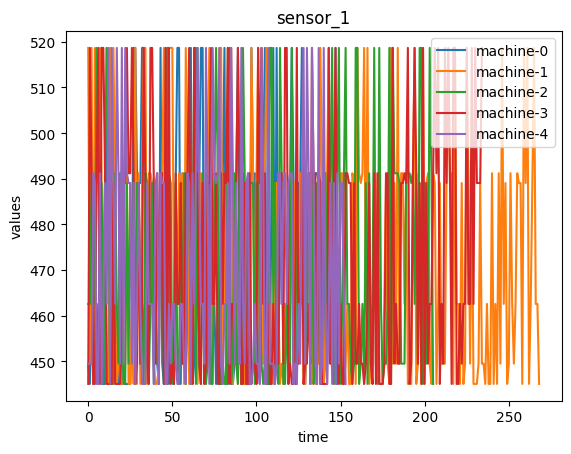

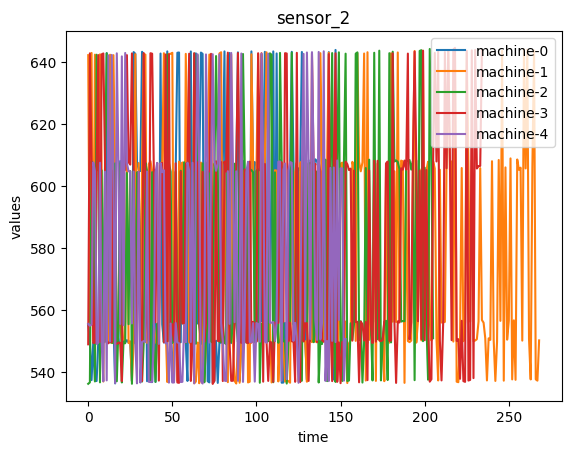

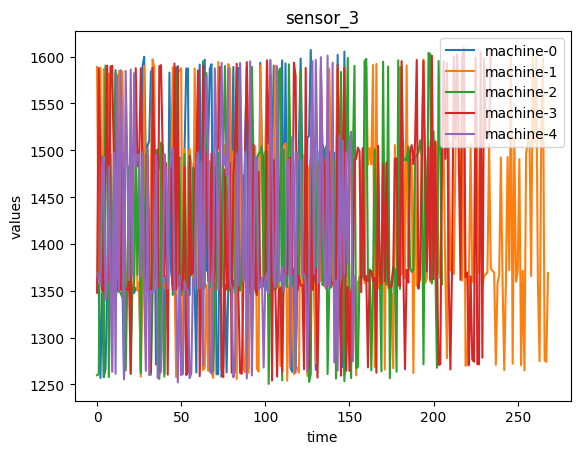

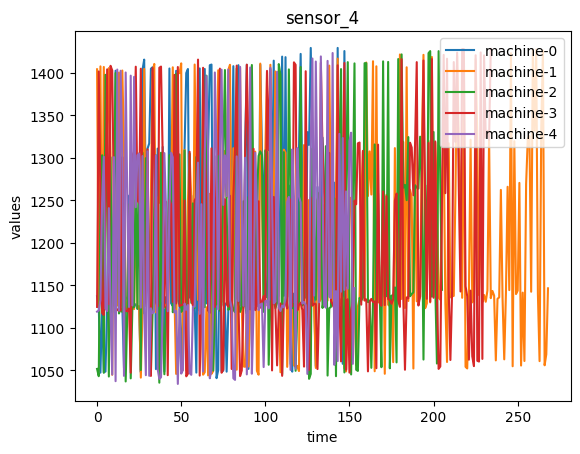

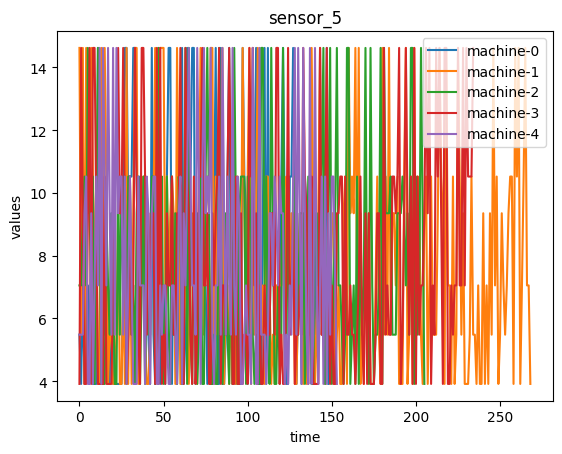

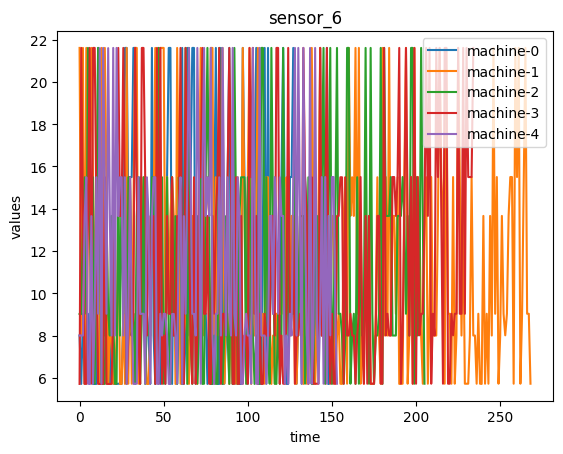

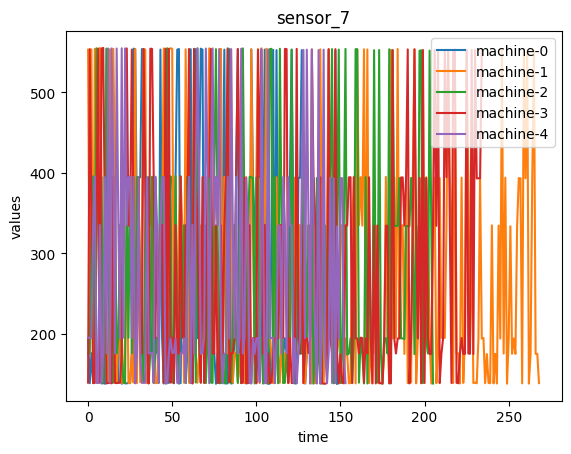

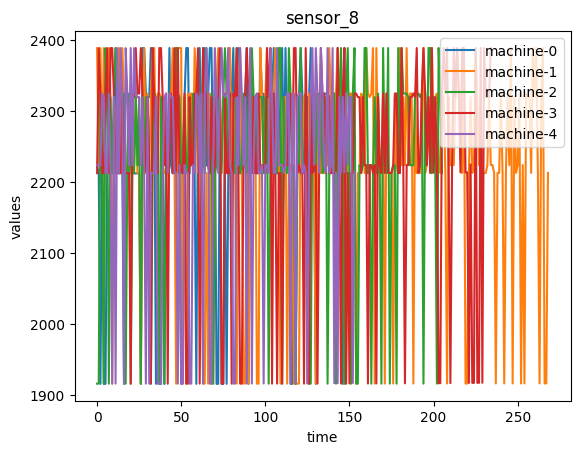

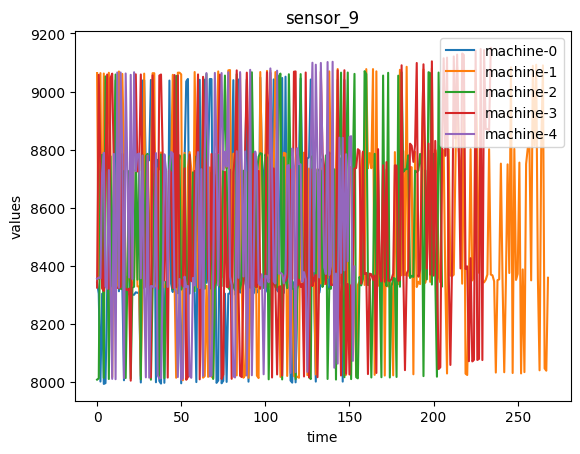

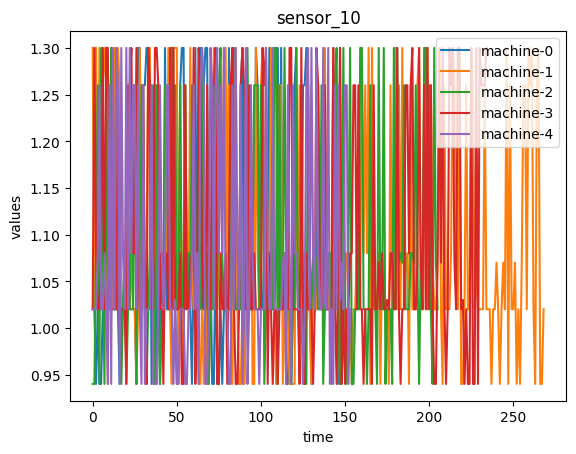

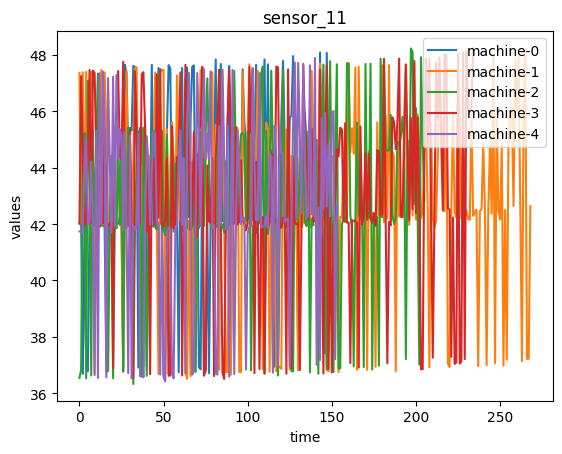

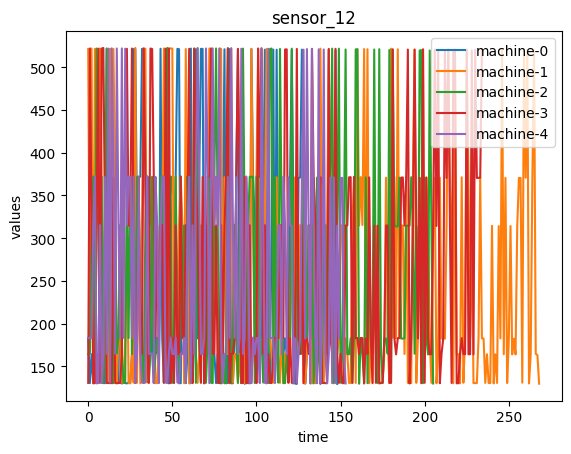

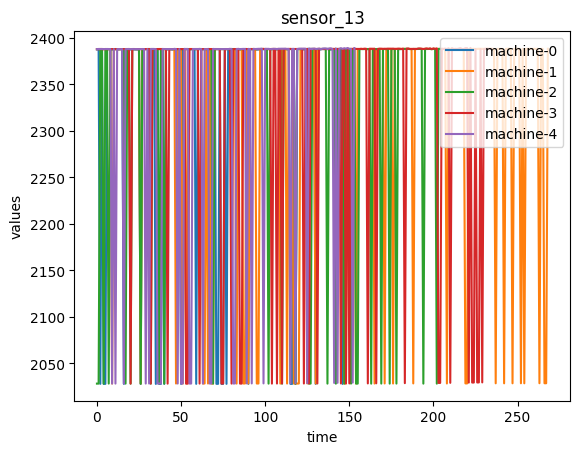

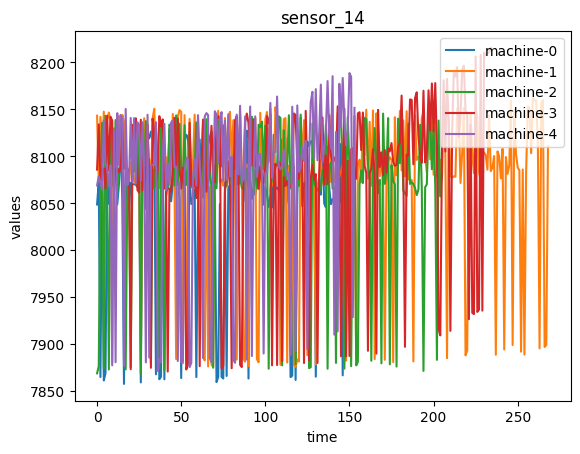

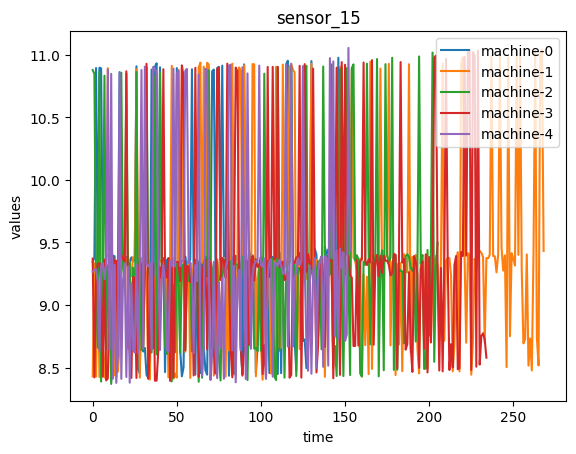

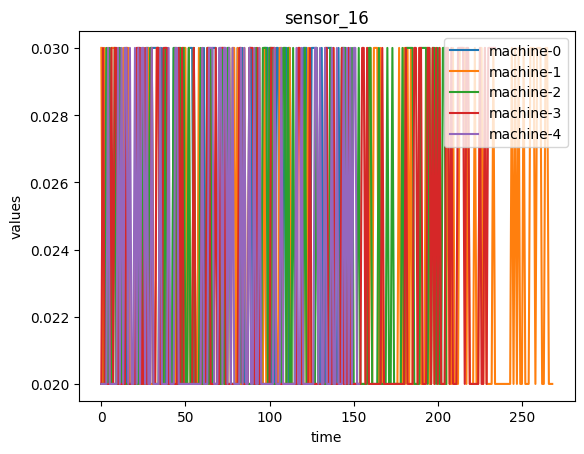

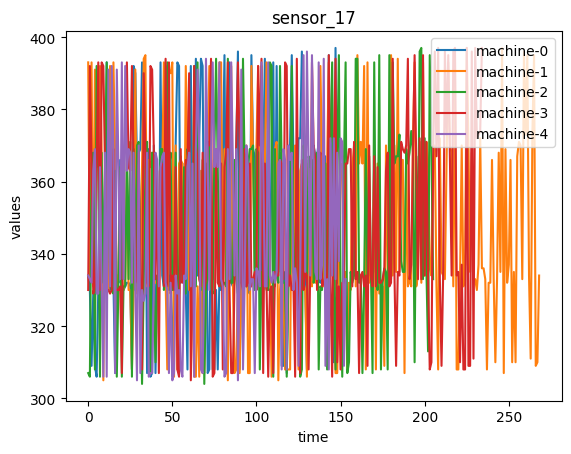

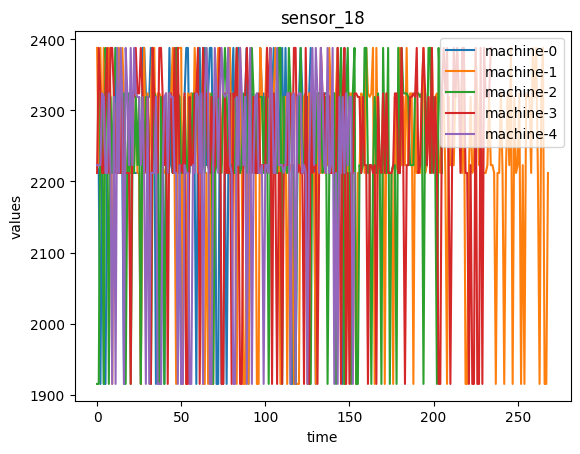

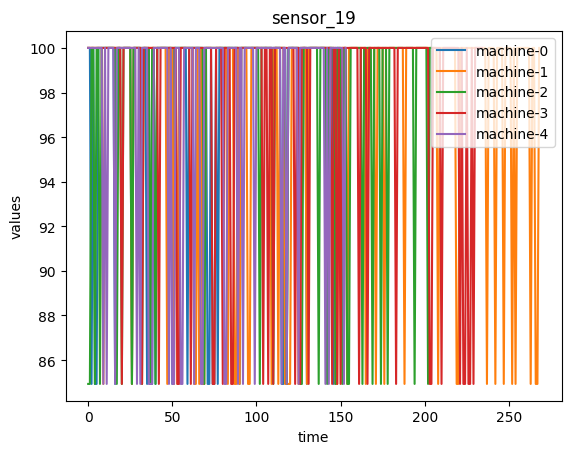

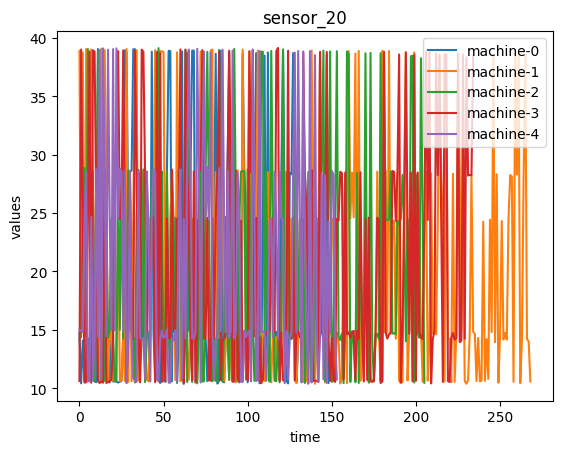

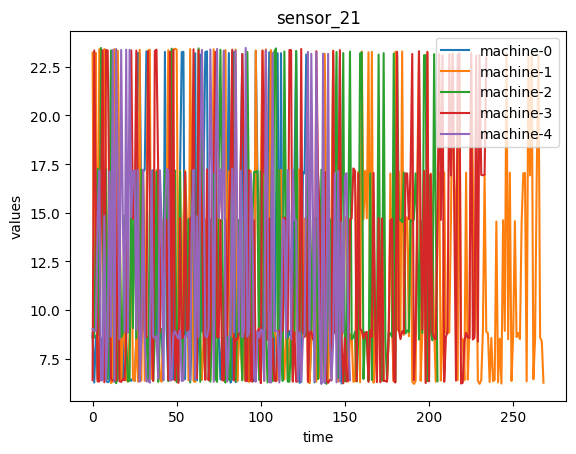

In [22]:
# Let's plot again  (Call split and Plot functions)
plot_func(sensor_header, column_names, data_list, n_samples)

Train-Validation Set Split

*   Due to the varying survival durations of the ensemble members or machines, the validation ensembles were selected randomly from the training population.

In [23]:
# Args
  # Ensemble data: Dataframe of all run-to-failure data from a fleet of engines
# Returns:
  # Train and validation sets
  # Unit IDs of the machines in the train and val sets
train_df, val_df, train_id, val_id = train_val_split(df=raw_train_df, val_percent=0.2)

# Check
val_df.shape[0] + train_df.shape[0] == raw_train_df.shape[0]

True

Features and targets

In [24]:
ytrain_df = train_df.pop('RUL')
yval_df = val_df.pop('RUL')
print(train_df.shape, ytrain_df.shape, val_df.shape, yval_df.shape)

(43201, 27) (43201,) (10558, 27) (10558,)


# Working regimen normalization (Set 2 and 4)

Create clusters

*   Run k-means model file
*   Load trained k-means model



In [25]:
loaded_model = joblib.load('C:/Users/Oluwaseyi/Downloads/kmeans_model')

Create clusters for the train, val and test datasets

In [26]:
op_condts_labels = ['op_conditions_1'	, 'op_conditions_2', 'op_conditions_3']
train_cluster_labels = kMeansClustering(kmeans_model = loaded_model, data=train_df, op_condts_labels=op_condts_labels)
val_cluster_labels = kMeansClustering(kmeans_model = loaded_model, data=val_df, op_condts_labels=op_condts_labels)
test_cluster_labels = kMeansClustering(kmeans_model = loaded_model, data=test_df, op_condts_labels=op_condts_labels)
print(train_cluster_labels.shape, val_cluster_labels.shape, test_cluster_labels.shape)
print(np.unique(train_cluster_labels), np.unique(val_cluster_labels), np.unique(test_cluster_labels))

(43201,) (10558,) (33991,)
[0 1 2 3 4 5] [0 1 2 3 4 5] [0 1 2 3 4 5]


X data prep

In [27]:
train_df.drop(columns=['Maxcycle'], inplace=True)
val_df.drop(columns=['Maxcycle'], inplace=True)

In [28]:
x_train = train_df.to_numpy()
x_val = val_df.to_numpy()
x_test = test_df.to_numpy()
print(x_train.shape, x_val.shape, x_test.shape)

(43201, 26) (10558, 26) (33991, 26)


Y data prep

In [29]:
y_train = ytrain_df.to_numpy()
y_val = yval_df.to_numpy()
y_test = np.squeeze(y_test).to_numpy()
print(y_train.shape, y_val.shape, y_test.shape)

(43201,) (10558,) (259,)


Normalize train dataset by cluster and save normalization parameters

*   Normalize sensors values by clusters
*   Remove NANs

*   Concatenate normalized sensor values with first 5 columns (unit_id, time & operating condts).






In [30]:
def WorkRegimenNorm(data, full_data, parameters_mean_list, parameters_std_list, cluster_labels, no_clusters):
  norm_data = normalize_regime(temp_data = data, cluster_labels = cluster_labels,
                                                  parameters_mean_list=parameters_mean_list,
                                                  parameters_std_list=parameters_std_list)

  # Some checks
  print('Normalized data shape before concat:', norm_data.shape)
  print('No of NaNs before fill:', np.isnan(norm_data).sum())   # Count NAns due to division error

  # Fill NANs with 0
  norm_data[np.isnan(norm_data)] = 0
  print('No of NaNs after fill:', np.isnan(norm_data).sum())

  # Conc first 5 cols
  conc_part = full_data[:full_data.shape[0],:5]
  # Add missing part
  norm_data = np.concatenate((conc_part,norm_data), axis=1)
  print('Normalized data shape after concat:', norm_data.shape)

  return norm_data

x_train data normalization

In [31]:
no_clusters

6

In [32]:
# Create temp unwrap data - 21 columns (only sensors)
cut_train = x_train[:,-21:]
parameters_mean_list, parameters_std_list = parameters_form(no_clusters=6, data=cut_train,
                                                            cluster_labels = train_cluster_labels)
print('parameter list shape:', parameters_mean_list[1].shape)

norm_x_train = WorkRegimenNorm(data=cut_train, full_data = x_train,
                               parameters_mean_list=parameters_mean_list, parameters_std_list=parameters_mean_list,
                               cluster_labels=train_cluster_labels, no_clusters=6)

6 6
parameter list shape: (21,)
Normalized data shape before concat: (43201, 21)
No of NaNs before fill: 0
No of NaNs after fill: 0
Normalized data shape after concat: (43201, 26)


x_val normalization

In [33]:
cut_val = x_val[:,-21:]
norm_x_val = WorkRegimenNorm(data=cut_val, full_data = x_val,
                               parameters_mean_list=parameters_mean_list, parameters_std_list=parameters_mean_list,
                               cluster_labels=val_cluster_labels, no_clusters=6)

Normalized data shape before concat: (10558, 21)
No of NaNs before fill: 0
No of NaNs after fill: 0
Normalized data shape after concat: (10558, 26)


x_test normalization

In [34]:
cut_test = x_test[:,-21:]
norm_x_test = WorkRegimenNorm(data=cut_test, full_data = x_test,
                               parameters_mean_list=parameters_mean_list, parameters_std_list=parameters_mean_list,
                               cluster_labels=test_cluster_labels, no_clusters=6)

Normalized data shape before concat: (33991, 21)
No of NaNs before fill: 0
No of NaNs after fill: 0
Normalized data shape after concat: (33991, 26)


Plots after normalization

In [35]:
vals = data_list = []  # List of arrays
for i in np.unique(norm_x_train[:,0]):
  ind = np.where(norm_x_train[:,0] == i)
  data_list.append(norm_x_train[ind])
print(len(data_list))

208


In [36]:
# n_samples = 10
column_names= list(raw_train_df.columns)
sensor_header = list(column_names[5:-2])

In [37]:
raw_train_df.columns

Index(['unit_id', 'time_cycle', 'op_conditions_1', 'op_conditions_2',
       'op_conditions_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'Maxcycle', 'RUL'],
      dtype='object')

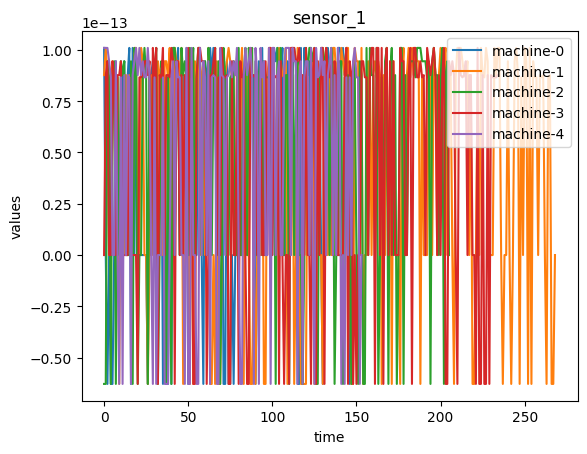

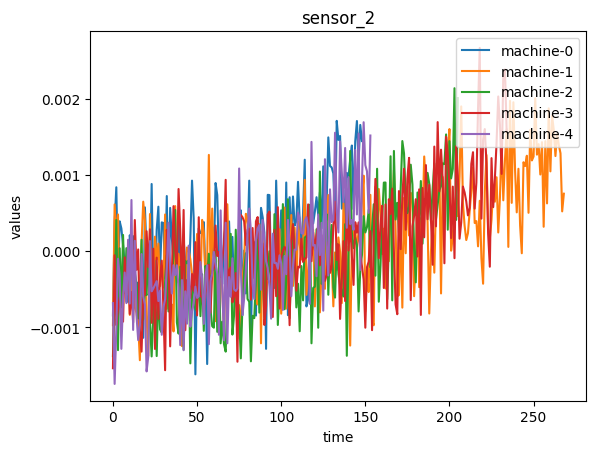

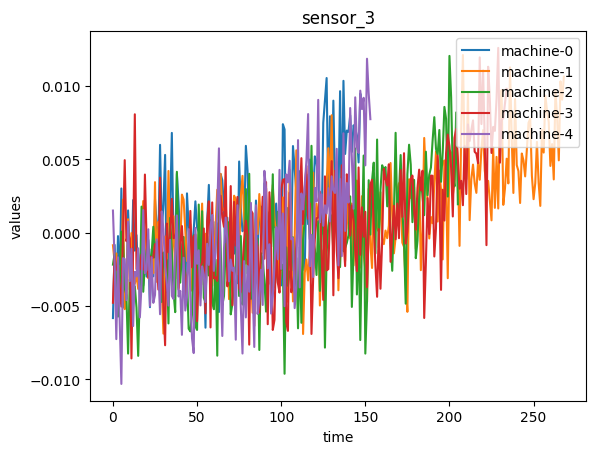

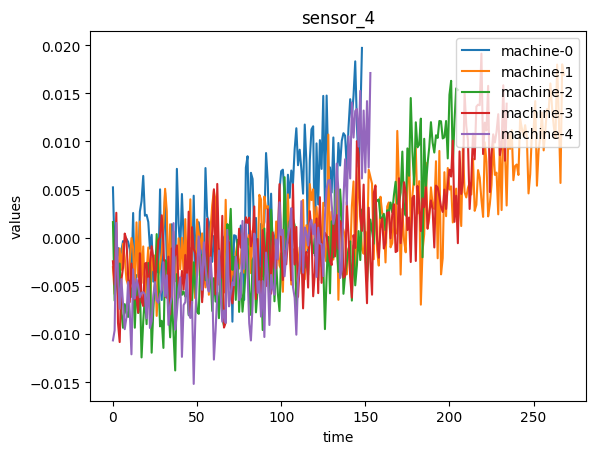

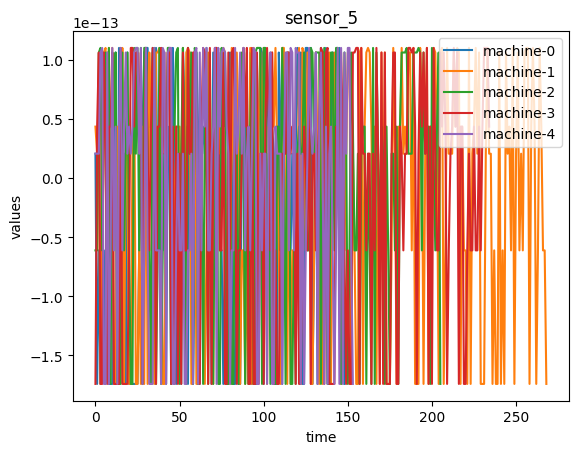

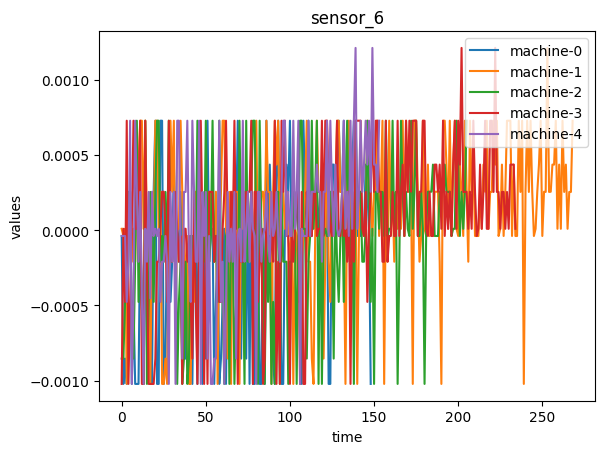

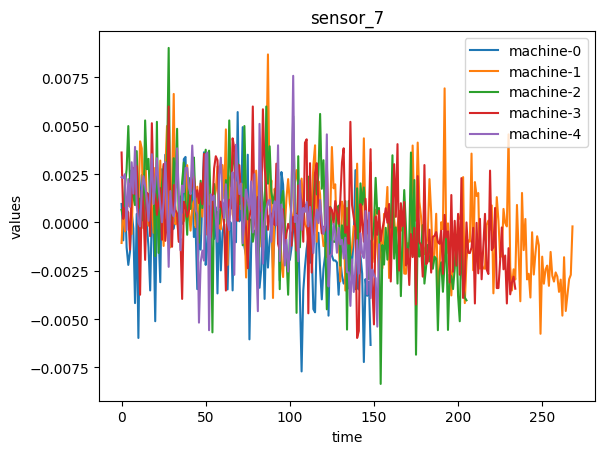

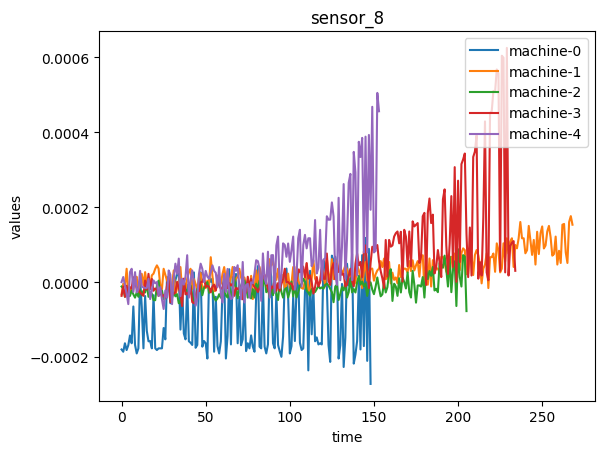

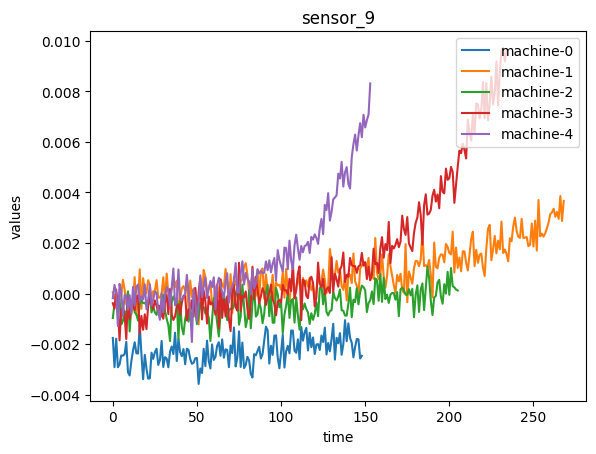

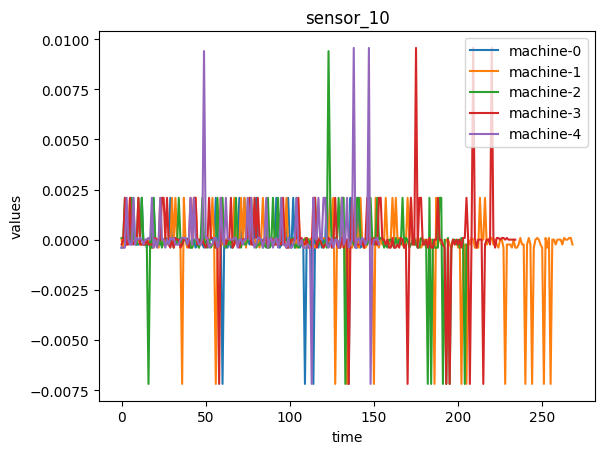

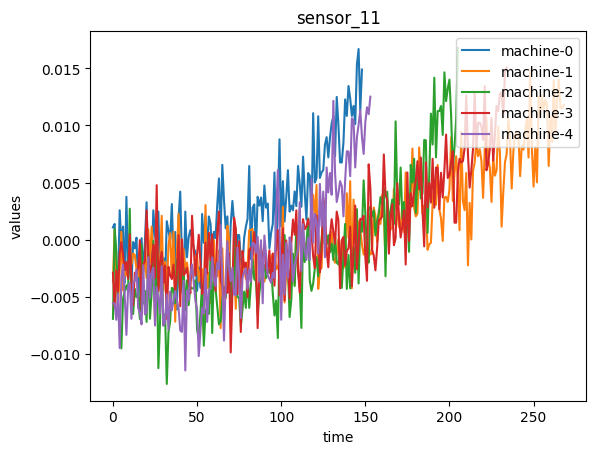

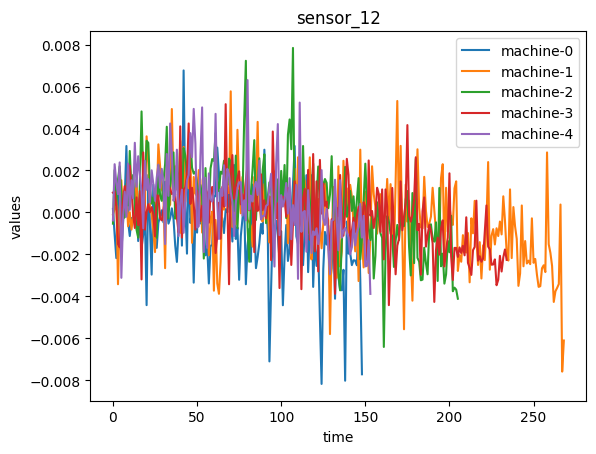

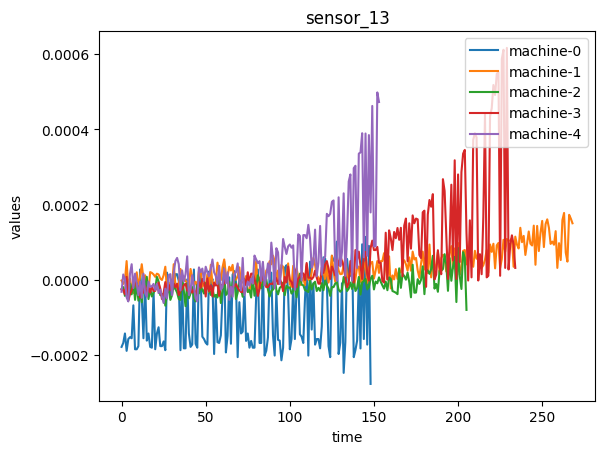

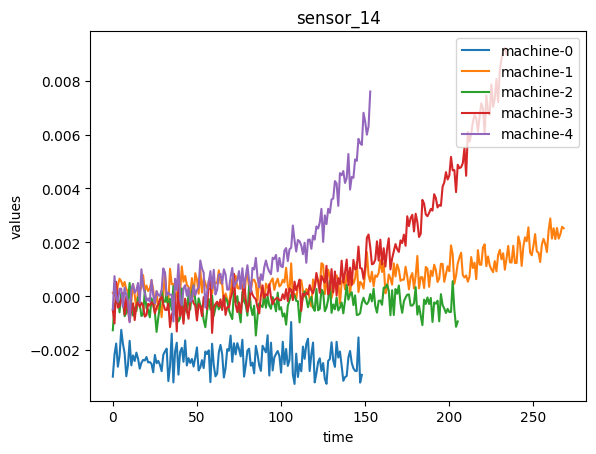

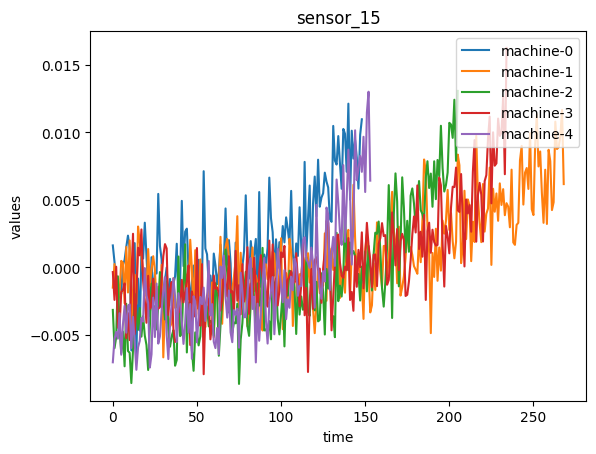

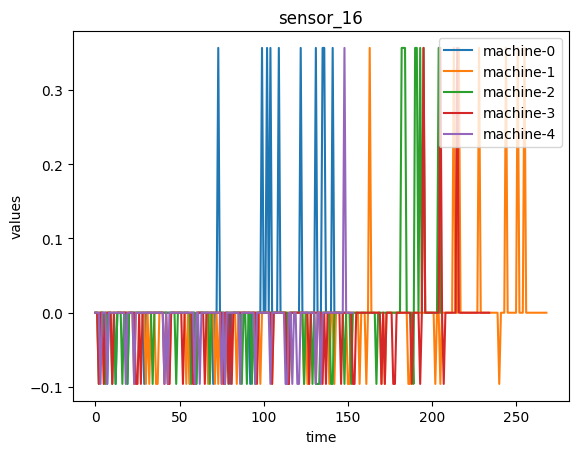

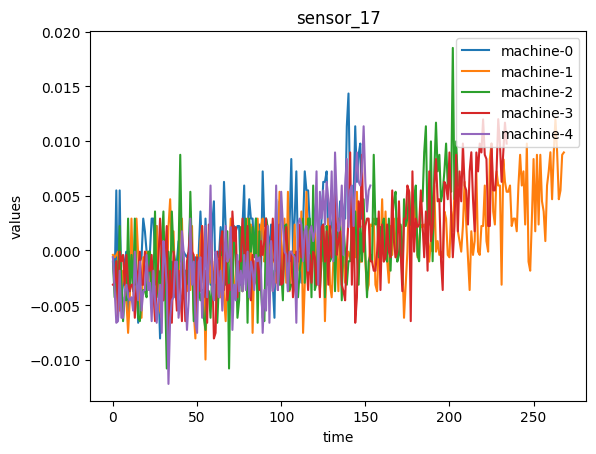

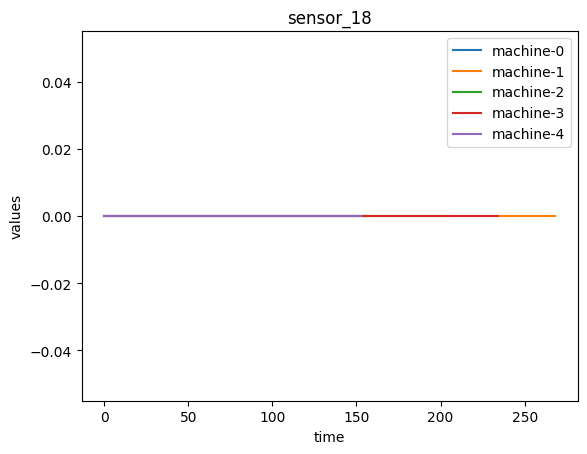

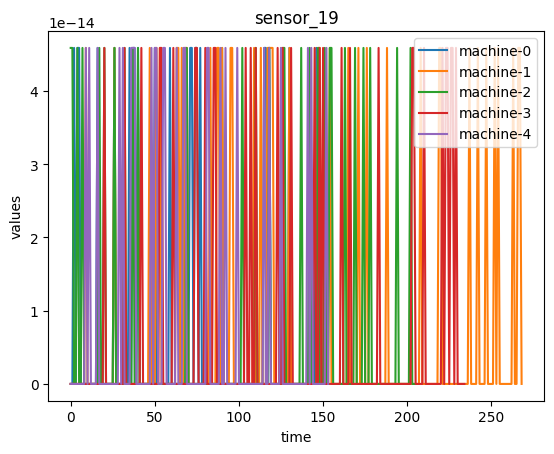

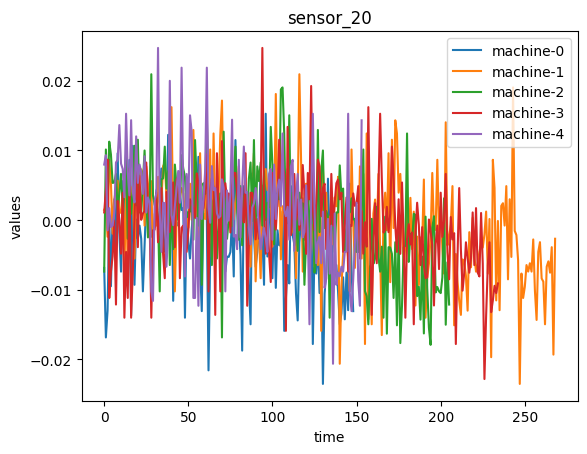

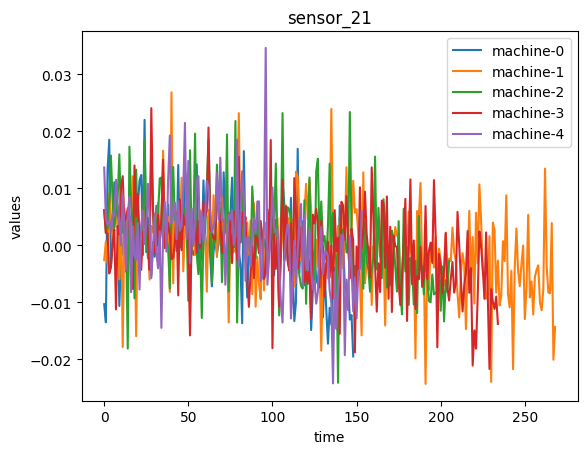

In [38]:
# Let's plot again  (Call split and Plot functions)
plot_func(sensor_header, column_names, data_list)

Feature Extraction

In [39]:
def featureExtraction(data, desired_sensors):
  cols = desired_sensors+4
  desired_cols = np.append(np.array([0]), cols)
  data = data[:,[desired_cols]]
  return data

In [40]:
desired_sensors = np.array([2,3,4,7,8,9,11,12,13,14,15,17,20,21])
Enorm_x_train = np.squeeze(featureExtraction(norm_x_train, desired_sensors))
Enorm_x_val = np.squeeze(featureExtraction(norm_x_val, desired_sensors))
Enorm_x_test = np.squeeze(featureExtraction(norm_x_test, desired_sensors))
print(Enorm_x_train.shape, Enorm_x_val.shape, Enorm_x_test.shape)

(43201, 15) (10558, 15) (33991, 15)


# Expanding \ Sliding Window (train, Val and test)

X-train, val, test prep

In [41]:
if max_len == T:
  x_train_list = slidingWindow(Enorm_x_train, T)
  x_val_list = slidingWindow(Enorm_x_val, T)
  x_test_list = testSlidingWindow(Enorm_x_test,T)
else:
  x_train_list = expandWindow(Enorm_x_train, min_len=5)
  x_val_list = expandWindow(Enorm_x_val, min_len=5)
  x_test_list = testExpandWindow(Enorm_x_test)
print(len(x_train_list), len(x_val_list), len(x_test_list))

42369 10350 259


 Y-train and val prep

In [42]:
y_train_ind = np.array([Enorm_x_train[:,0], y_train])
y_val_ind =  np.array([Enorm_x_val[:,0], y_val])
y_train_ind = np.transpose(y_train_ind)
y_val_ind = np.transpose(y_val_ind)
print(y_train_ind.shape, y_val_ind.shape)

(43201, 2) (10558, 2)


In [43]:
if max_len == T:
  min_len = T

y_train_list = yPrep(y_train_ind, min_len)
y_val_list = yPrep(y_val_ind, min_len)
print(len(y_train_list), len(y_val_list))

208 52


In [44]:
print(checkY(y_train_list), checkY(y_val_list))

42369 10350


In [45]:
y_trainf = np.concatenate(y_train_list)
y_valf = np.concatenate(y_val_list)
print(y_trainf.shape, y_valf.shape)

(42369,) (10350,)


You might want to save these prepared datasets and reload later

In [46]:
# np.save('FD04_x_train', x_train_list, allow_pickle=True)
# np.save('FD04_x_val', x_val_list, allow_pickle=True)
# np.save('FD04_y_train', y_trainf)
# np.save('FD04_y_val', y_valf)

Use Piecewise RUL values

In [47]:
y_trainf = np.where(y_trainf>125, 125,y_trainf)
y_valf = np.where(y_valf>125, 125,y_valf)
y_testf = np.where(y_test>125, 125,y_test)
print(y_trainf.shape, y_valf.shape, y_testf.shape)

(42369,) (10350,) (259,)


Min-max normalization of y

In [48]:
y_trainf = y_trainf.reshape(-1,1)
y_valf = y_valf.reshape(-1,1)
y_testf = y_testf.reshape(-1,1)
print(y_trainf.shape, y_valf.shape, y_testf.shape)

(42369, 1) (10350, 1) (259, 1)


In [49]:
y_scaler = MinMaxScaler()
y_scaler.fit(y_trainf)
y_trainf = y_scaler.transform(y_trainf)
y_valf = y_scaler.transform(y_valf)
y_testf = y_scaler.transform(y_testf)
print(y_trainf.shape, y_valf.shape, y_testf.shape)

(42369, 1) (10350, 1) (259, 1)


In [50]:
y_trainf = y_trainf.squeeze()
y_valf = y_valf.squeeze()
y_testf = y_testf.squeeze()
print(y_trainf.shape, y_valf.shape, y_testf.shape)

(42369,) (10350,) (259,)


Prepare dataset for use in pytorch

In [51]:
def collate_superv(data, max_len=max_len):
    """Build mini-batch tensors from a list of (X, y) tuples.
    Args:
        data: len(batch_size) list of tuples (X, y).
            - X: torch tensor of shape (seq_length, feat_dim); variable seq_length.
            - y: torch tensor of shape (1);
        max_len: global fixed sequence length. Used for architectures requiring fixed length input,
            where the batch length cannot vary dynamically. Longer sequences are clipped, shorter are padded with 0s
    Returns:
        X: (batch_size, padded_length, feat_dim) torch tensor of masked features (input)
        y: (batch_size,1)
        padding_masks: (batch_size, padded_length) boolean tensor, 1 means keep vector at this position, 0 ignore (padding)
    """

    batch_size = len(data)
    features, targets = zip(*data)

    # Stack and pad features and masks (convert 2D to 3D tensors, i.e. add batch dimension)
    lengths = [X.shape[0] for X in features]  # original sequence length for each time series
    if max_len is None:
        max_len = max(lengths)

    X = torch.zeros(batch_size, max_len, features[0].shape[-1])  # (batch_size, padded_length, feat_dim)

    for i in range(batch_size):
        end = min(lengths[i], max_len)
        X[i, :end, :] = features[i][:end, :]

    padding_masks = padding_mask(torch.tensor(lengths, dtype=torch.int16), max_len=max_len)  # (batch_size, padded_length) boolean tensor, "1" means keep
    # X = x.clone().detach().requires_grad_(True)
    X = X.clone().detach().requires_grad_(True).type('torch.FloatTensor')
    targets = torch.tensor(targets, dtype=torch.float).reshape(-1,1)
    return X, targets, padding_masks

In [52]:
train_dataset = supDataset(data_list=x_train_list, targets=y_trainf)
train_dataloader = DataLoader(dataset=train_dataset,
                    collate_fn=collate_superv,
                    batch_size=128,
                    shuffle=False,
                    # num_workers=2,
                    pin_memory=True)

Some checks

In [53]:
for ret in train_dataloader:

  # X, targets, padding_masks = batch
  break
print(ret[0].shape, ret[1].shape, ret[2].shape)

torch.Size([128, 378, 14]) torch.Size([128, 1]) torch.Size([128, 378])


In [54]:
torch.sum(ret[2], axis=1)

tensor([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
         33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
         47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
         61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
         75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132])

In [55]:
val_dataset = supDataset(data_list=x_val_list, targets=y_valf)
val_dataloader = DataLoader(dataset=val_dataset,
                    collate_fn=collate_superv,
                    batch_size=128,
                    shuffle=False,
                    # num_workers=2,
                    pin_memory=True)

In [56]:
test_dataset = supDataset(data_list=x_test_list, targets=y_testf)
test_dataloader = DataLoader(dataset=test_dataset,
                    collate_fn=collate_superv,
                    batch_size=y_testf.shape[0],
                    shuffle=False,
                    # num_workers=2,
                    pin_memory=True)

# Training and Validation

Create device Object

In [57]:
# Create device object to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Train Function

In [58]:
from datetime import datetime
def train_eval(model, criterion, optimizer, train_dataloader, val_dataloader, patience, epochs, exp_no, transform):
  # Collect the train and test loss per epoch
  train_losses = []
  test_losses = []

  # early_stop_thresh = patience
  best_loss = float('inf')
  best_epoch = -1
  patience=patience

  # Loop over no of epochs
  for epoch in range(epochs):
    t0 = datetime.now()
    # Put model in training mode
    model.train()

    # accumulate loss per batch in one epoch
    train_epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch

    for batch in train_dataloader:

      X, targets, padding_masks = batch[0], batch[1], batch[2]

      # move data to GPU/ any available device
      X = X.to(device)
      targets = targets.to(device)
      padding_masks = padding_masks.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward Pass
      # regression: (batch_size, num_labels); classification: (batch_size, num_classes) of logits
      predictions = model(X, padding_masks, transform)
      loss = criterion(predictions, targets)  # (batch_size,) loss for each sample in the batch

      # Backward and optimize
      loss.backward()   # Compute Gradients (Back prop)
      optimizer.step()  # Update weights(GD/Adam)

      # Loss of this batch in this epoch
      train_epoch_loss += float(loss.item())*(X.shape[0])
      total_samples += X.shape[0]

    # Get average train loss
    train_epoch_loss = train_epoch_loss / total_samples

    # Make predictions with model at the end of each epoch
    test_epoch_loss = 0
    n_test = 0

    for batch in val_dataloader:
      X, targets, padding_masks = batch[0], batch[1], batch[2]
      # Move test data to device
      X = X.to(device)
      targets = targets.to(device)
      padding_masks = padding_masks.to(device)

      with torch.inference_mode():
        model.eval()
        predictions = model(X, padding_masks, transform)

      loss = criterion(predictions, targets)

      test_epoch_loss += float(loss.item()) *(X.shape[0])
      n_test += X.shape[0]

    test_epoch_loss = test_epoch_loss / n_test

    # Save losses
    train_losses.append(train_epoch_loss)
    test_losses.append(test_epoch_loss)

    dt = datetime.now() - t0
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_epoch_loss:.4f}, \
      Test Loss: {test_epoch_loss:.4f}, Duration: {dt}')

    # MODEL TRACKING/CHECKPOINTS FUNCTIONS
    if test_epoch_loss < best_loss:
      best_loss = test_epoch_loss
      best_epoch = epoch
      torch.save(model, "best_model" + str(exp_no) + ".pt")
    if (epoch - best_epoch) > patience:
      print("Early stopped training at epoch %d" % (epoch+1))
      break  # terminate the training loop
    best_model = torch.load("best_model" + str(exp_no) + ".pt")
  return best_model, best_epoch, train_losses, test_losses

Score function

In [59]:
def score(errors):
  a1=10
  a2=13
  s1=0
  s2=0
  for err in errors:
    if err < 0:
      s1 += (np.exp(-1*(err/a1))) - 1
    if ((err > 0) or (err == 0)):
      s2 += (np.exp(err/a2)) - 1
  return [s1 , s2]

Put It All Together.

In [60]:
d_model = 14
transform = 'linear'

In [61]:
# Instantiate model
# Dropout 0.4 is the sweet spot
model = TSTransformerEncoderClassiregressor(feat_dim=14, max_len=max_len, d_model=d_model, n_heads=2, num_layers=2, dim_feedforward=10, num_classes=1,
                 dropout=0.4, pos_encoding='fixed', activation='gelu', norm='LayerNorm', freeze=False, transform=transform)
# Move model to the gpu if available ()
# Note: If you need to move a model to GPU via .cuda() ,
# please do so before constructing optimizers for it. Parameters of a model after .cuda() will be different objects with those before the call.
model.to(device)

# Instantiate loss and optimizer of choice
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


In [ ]:
# Call the train function
best_model, best_epoch, train_losses, val_losses = train_eval(model, criterion, optimizer, train_dataloader,
                                                              val_dataloader, patience=20, epochs=150, exp_no=1, transform=transform)

# Plot Loss
plot_loss_accuracy("Transformer", train_losses=train_losses, test_losses=val_losses)

# Validation

In [68]:
with torch.inference_mode():
  best_model.eval()

  for batch in val_dataloader:

    X, targets, padding_masks = batch[0], batch[1], batch[2]

    # move data to GPU/ any available device
    X = X.to(device)
    targets = targets.to(device)
    padding_masks = padding_masks.to(device)

    # Make predictions with best model
    y_pred = best_model(X, padding_masks, transform)

In [ ]:
y_predb = torch.Tensor.cpu(y_pred).detach().numpy()
y_test = torch.Tensor.cpu(targets).detach().numpy()

# Inverse transform
y_predb = y_scaler.inverse_transform(y_predb)
y_test = y_scaler.inverse_transform(y_test)

# Get score and RMSE
RMSE = mean_squared_error(y_predb, y_test, squared=False)
MAE = mean_absolute_error(y_predb, y_test)
error = y_predb -  y_test
SCORES = score(error)
print(SCORES,RMSE, MAE)

# Testing

In [70]:
with torch.inference_mode():
  best_model.eval()

  for batch in test_dataloader:

    X, targets, padding_masks = batch[0], batch[1], batch[2]

    # move data to GPU/ any available device
    X = X.to(device)
    targets = targets.to(device)
    padding_masks = padding_masks.to(device)

    # Make predictions with best model
    y_pred = best_model(X, padding_masks, transform)

In [71]:
y_predb = torch.Tensor.cpu(y_pred).detach().numpy()
y_test = torch.Tensor.cpu(targets).detach().numpy()

# Inverse transform
y_predb = y_scaler.inverse_transform(y_predb)
y_test = y_scaler.inverse_transform(y_test)

# Get score and RMSE
RMSE = mean_squared_error(y_predb, y_test, squared=False)
MAE = mean_absolute_error(y_predb, y_test)
error = y_predb -  y_test
SCORES = score(error)
print(SCORES, RMSE, MAE)

[array([286.6205], dtype=float32), array([276.5346], dtype=float32)] 12.262278 9.134875


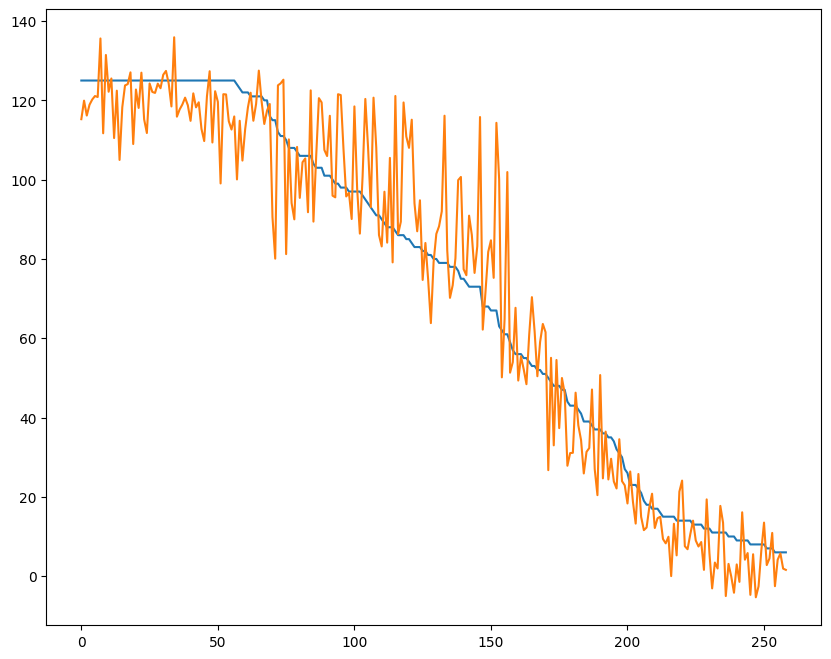

In [67]:
ind = np.argsort(-y_test.squeeze(1))
plt.figure(figsize=(10,8));
plt.plot(y_test[ind]);
plt.plot(y_predb[ind]);